# **Tumor Detection**

## 1. Import Libraries and Modules

In [2]:
# import system libs 
import os
import time
import shutil
import itertools
import seaborn as sns
import random
import glob
import time
from skimage import io

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from skimage.color import rgb2gray

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Input, Lambda,Conv2DTranspose, concatenate
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('modules loaded')

modules loaded


## 2.Load Data

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')
print('Size of the Training Data :',tr_df.shape)

ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')
print('Size of the Testing Data :',ts_df.shape)

Size of the Training Data : (5712, 2)
Size of the Testing Data : (1311, 2)


In [5]:
tr_df

Class Path      Class
0     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4     /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
...                                                 ...        ...
5707  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5708  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5709  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5710  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma
5711  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma

[5712 rows x 2 columns]

## 3.Visualization

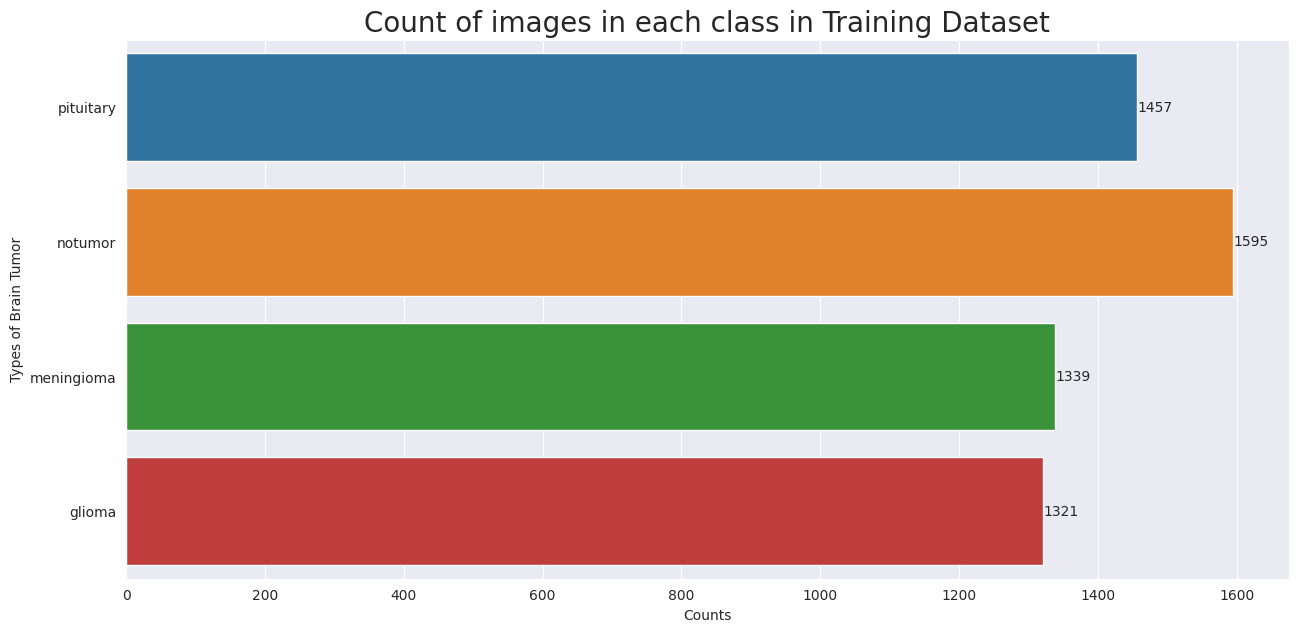

In [6]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot( y=tr_df['Class'])

plt.xlabel('Counts')
plt.ylabel('Types of Brain Tumor')
plt.title('Count of images in each class in Training Dataset', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

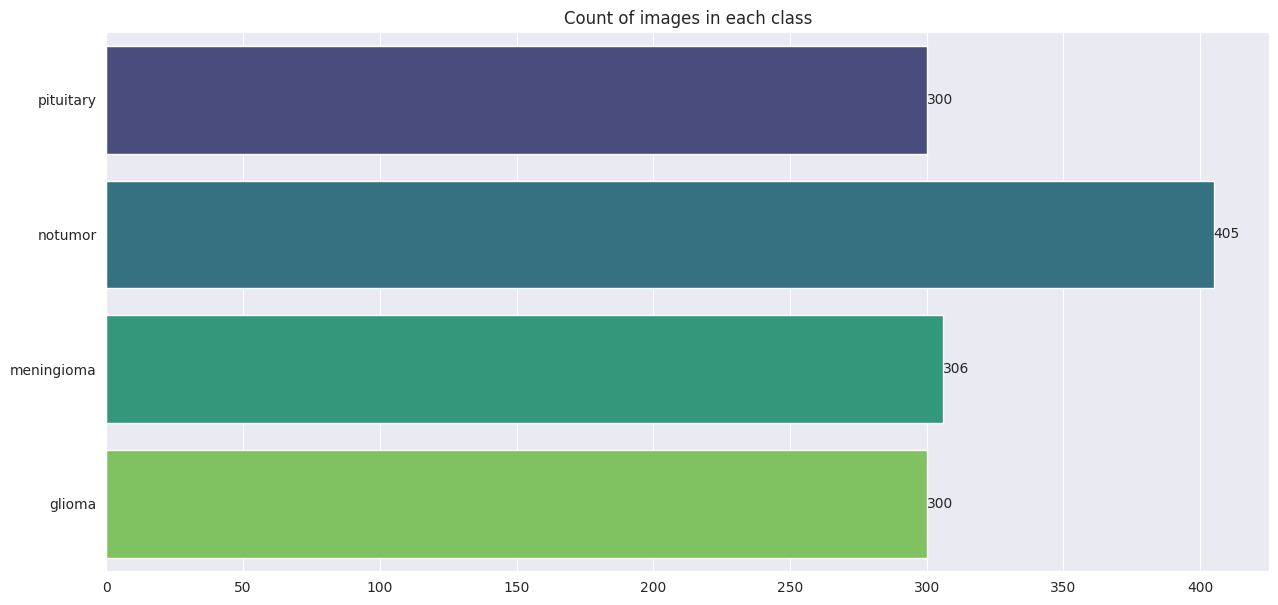

In [7]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

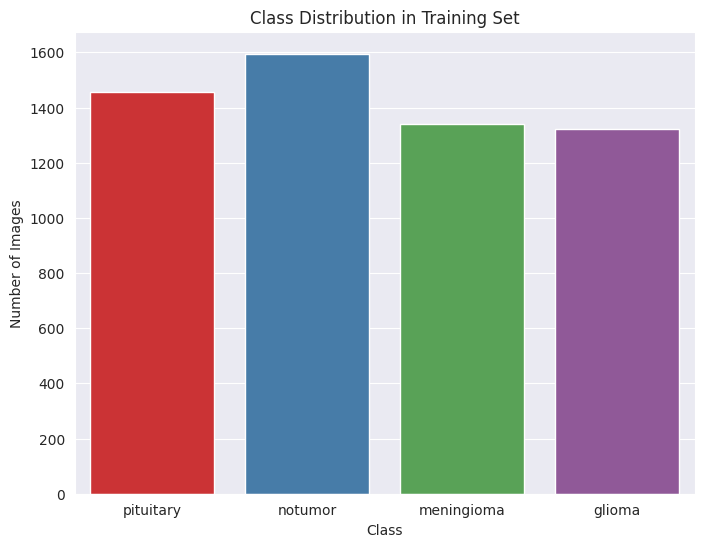

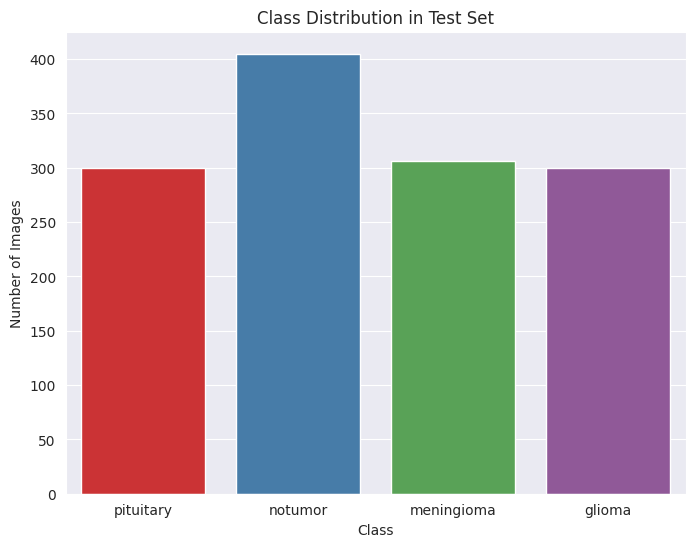

In [8]:

custom_palette = sns.color_palette("Set1", len(tr_df['Class'].unique()))

# Plot class distribution in the training set with different colors
plt.figure(figsize=(8, 6))
sns.countplot(data=tr_df, x='Class', palette=custom_palette)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Plot class distribution in the test set with different colors
plt.figure(figsize=(8, 6))
sns.countplot(data=ts_df, x='Class', palette=custom_palette)
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

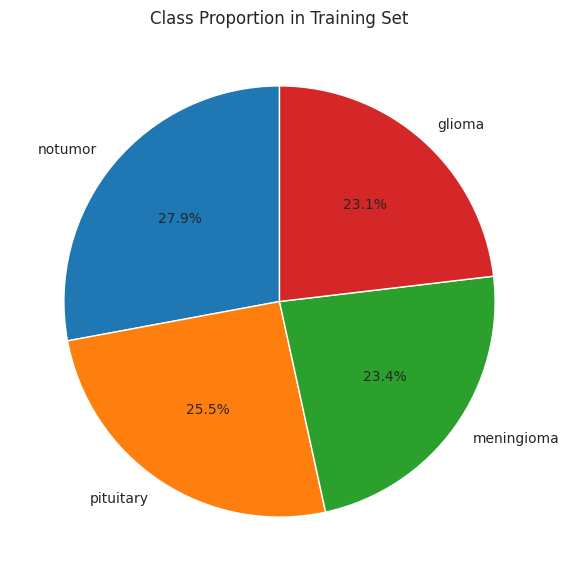

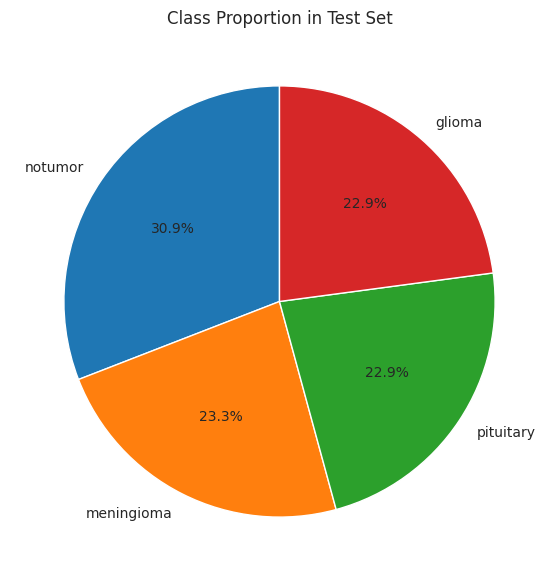

In [9]:
# Pie chart for training set class distribution
train_class_counts = tr_df['Class'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(train_class_counts, labels=train_class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Proportion in Training Set')
plt.show()

# Pie chart for test set class distribution
test_class_counts = ts_df['Class'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(test_class_counts, labels=test_class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Proportion in Test Set')
plt.show()

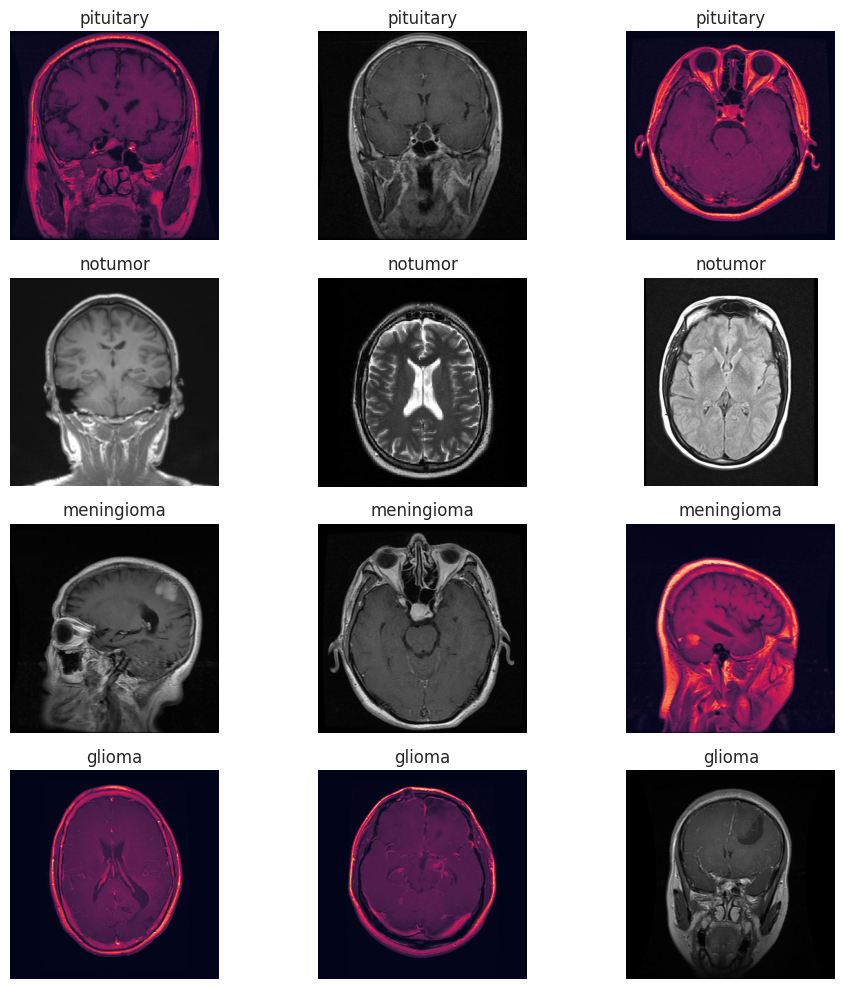

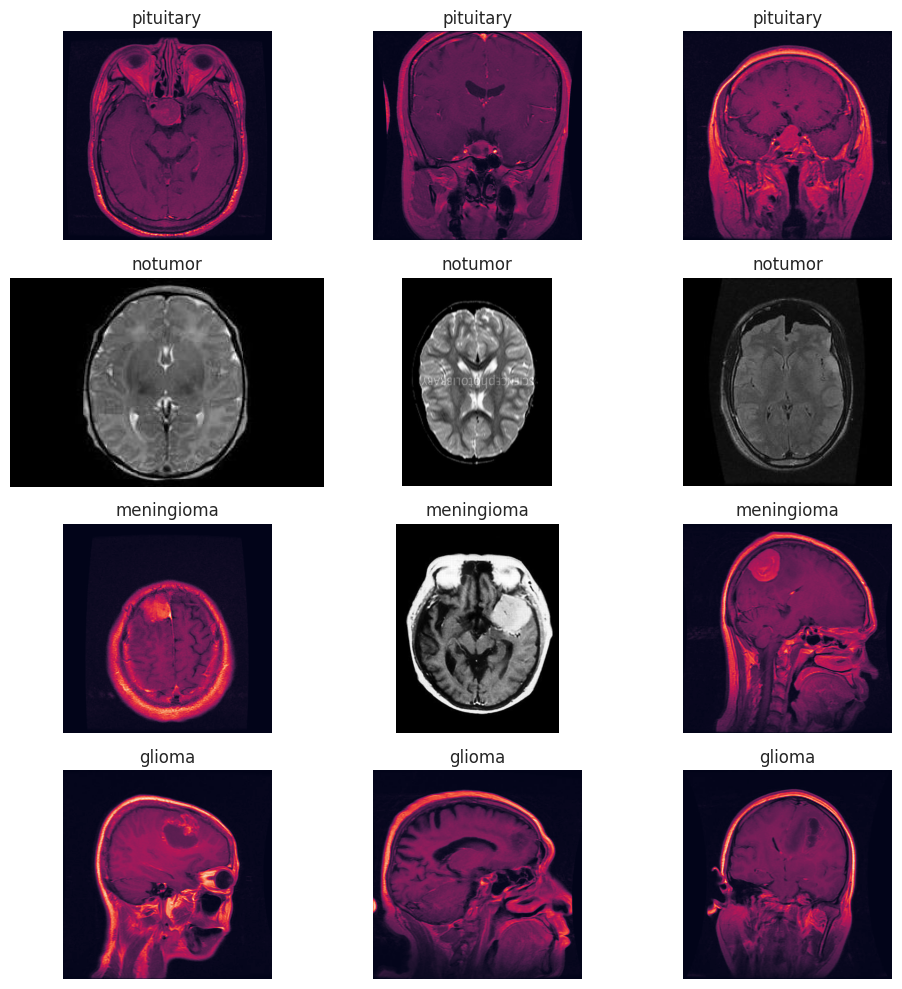

In [10]:
import numpy as np
import random
from PIL import Image

# Function to display sample images from each class
def show_sample_images(df, num_samples=4):
    plt.figure(figsize=(10, 10))

    for i, class_name in enumerate(df['Class'].unique()):
        # Get random samples from the class
        sample_images = df[df['Class'] == class_name].sample(num_samples)

        for j, file_path in enumerate(sample_images['Class Path']):
            img = Image.open(file_path)
            plt.subplot(len(df['Class'].unique()), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images from the training set
show_sample_images(tr_df,3)

# Display sample images from the test set
show_sample_images(ts_df,3)


## 4.Data Augmentation

In [11]:
tr_df, vl_df = train_test_split(tr_df,  train_size= 0.85, shuffle= True, random_state= 99, stratify= tr_df['Class'])
tr_df

Class Path       Class
5615  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
2967  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
3072  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
5711  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
5533  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
...                                                 ...         ...
4585  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
2628  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
184   /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary
4765  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
324   /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary

[4855 rows x 2 columns]

In [12]:
vl_df

Class Path       Class
4894  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
5390  /kaggle/input/brain-tumor-mri-dataset/Training...      glioma
3549  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
94    /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary
3534  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma
...                                                 ...         ...
1210  /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary
2041  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
1926  /kaggle/input/brain-tumor-mri-dataset/Training...     notumor
1279  /kaggle/input/brain-tumor-mri-dataset/Training...   pituitary
4027  /kaggle/input/brain-tumor-mri-dataset/Training...  meningioma

[857 rows x 2 columns]

In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2),
                          rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(vl_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 4855 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [14]:
# Print the number of original training images
print("Number of original training images:", tr_gen.samples)

# If you want to see how many batches are created per epoch
print("Number of batches per epoch:", tr_gen.n // tr_gen.batch_size)

Number of original training images: 4855
Number of batches per epoch: 151


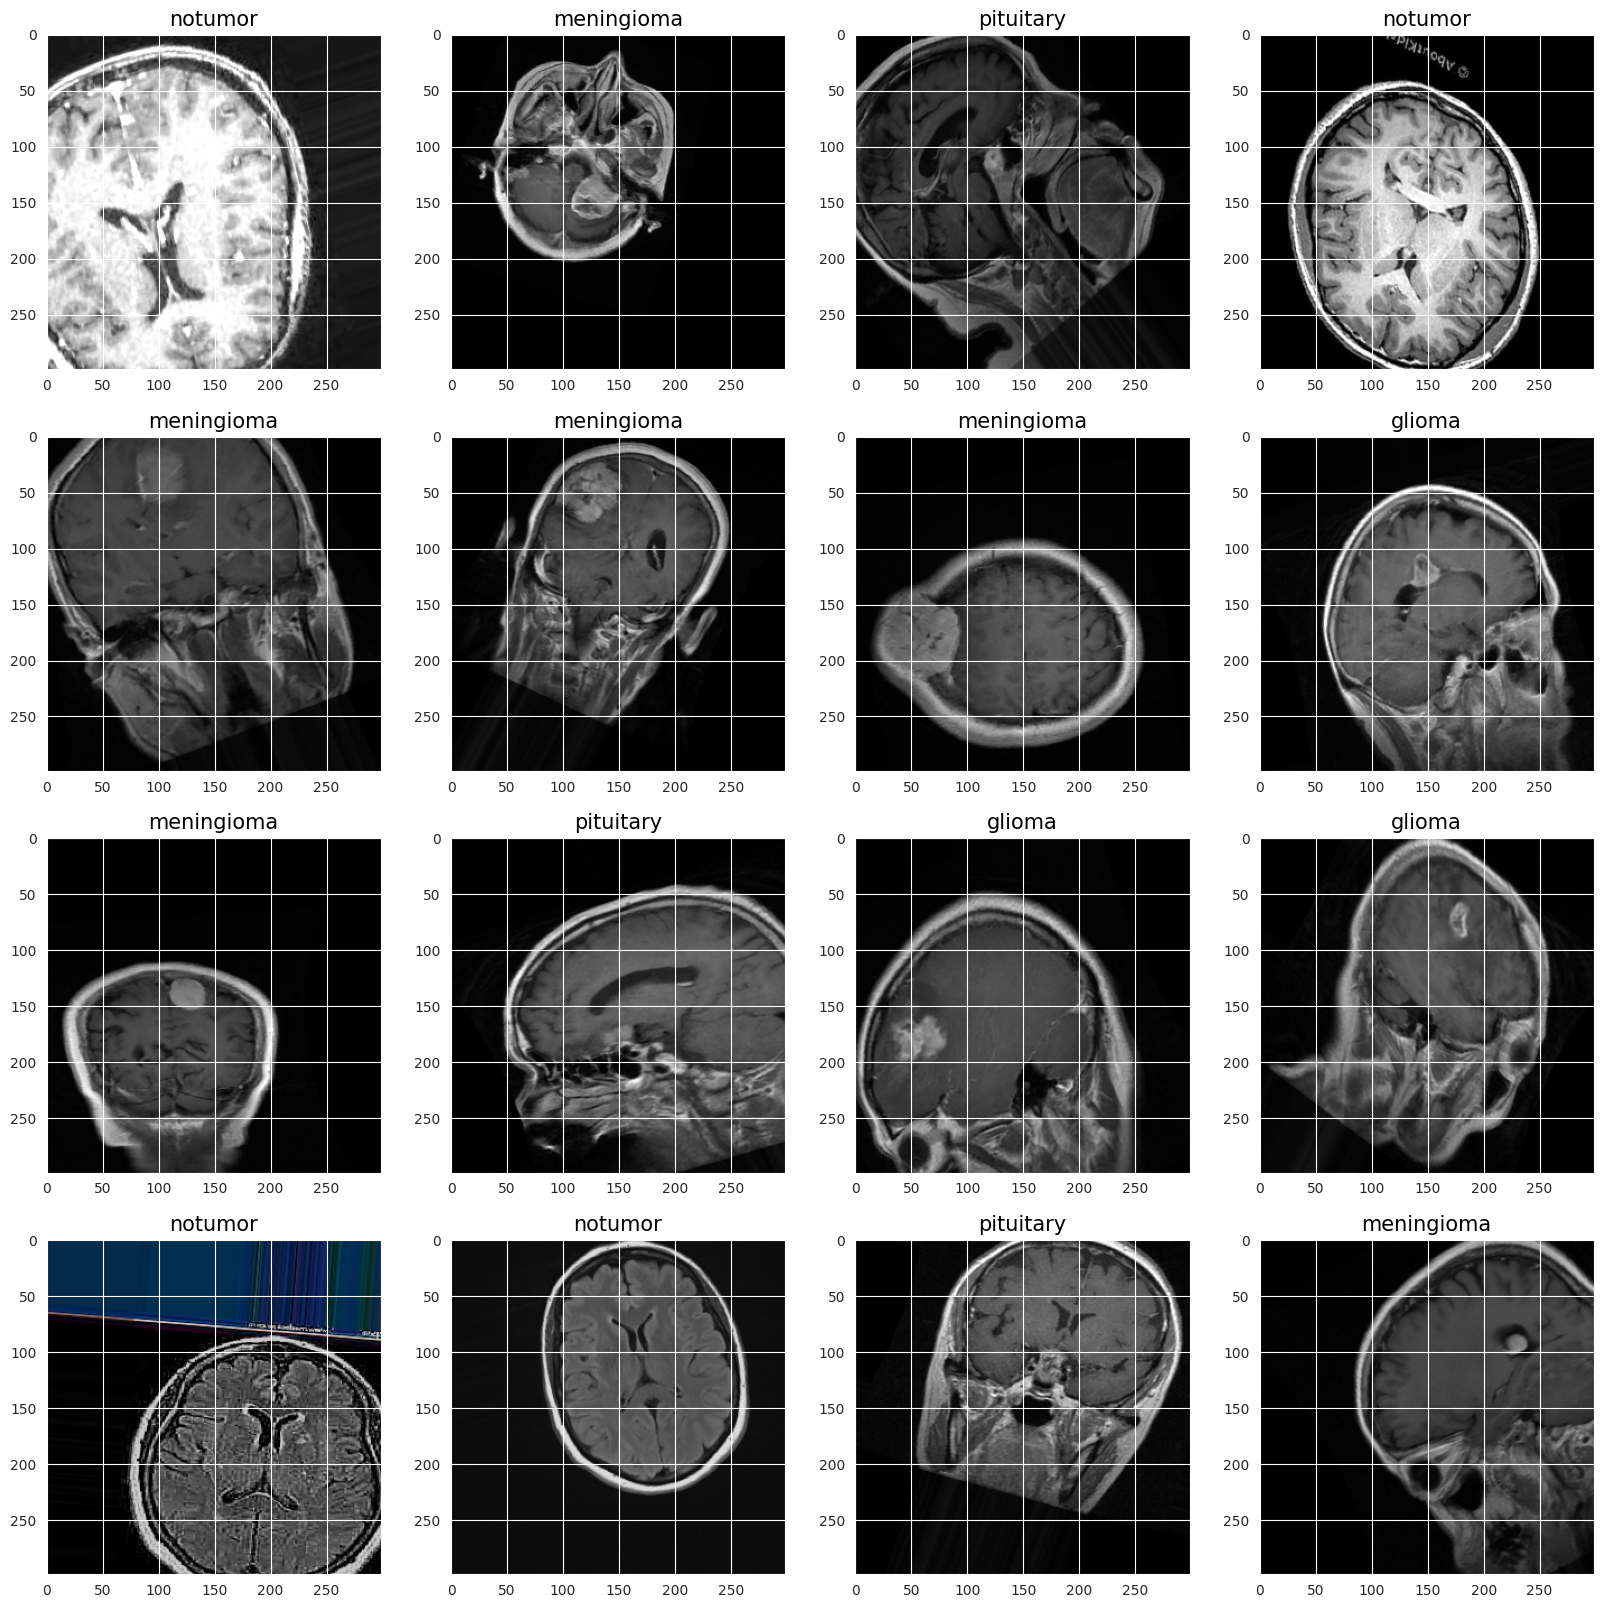

In [15]:
class_dict = tr_gen.class_indices
#{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    if i==16:
        break
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# This gets random samples form the data

## 5. Building the Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

# Define input shape and base model
img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)

# Uncomment the following lines if you want to freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')  # Adjust based on your number of classes
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Ensure all layers are built before calling `model.summary()`
model.build((None, *img_shape))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

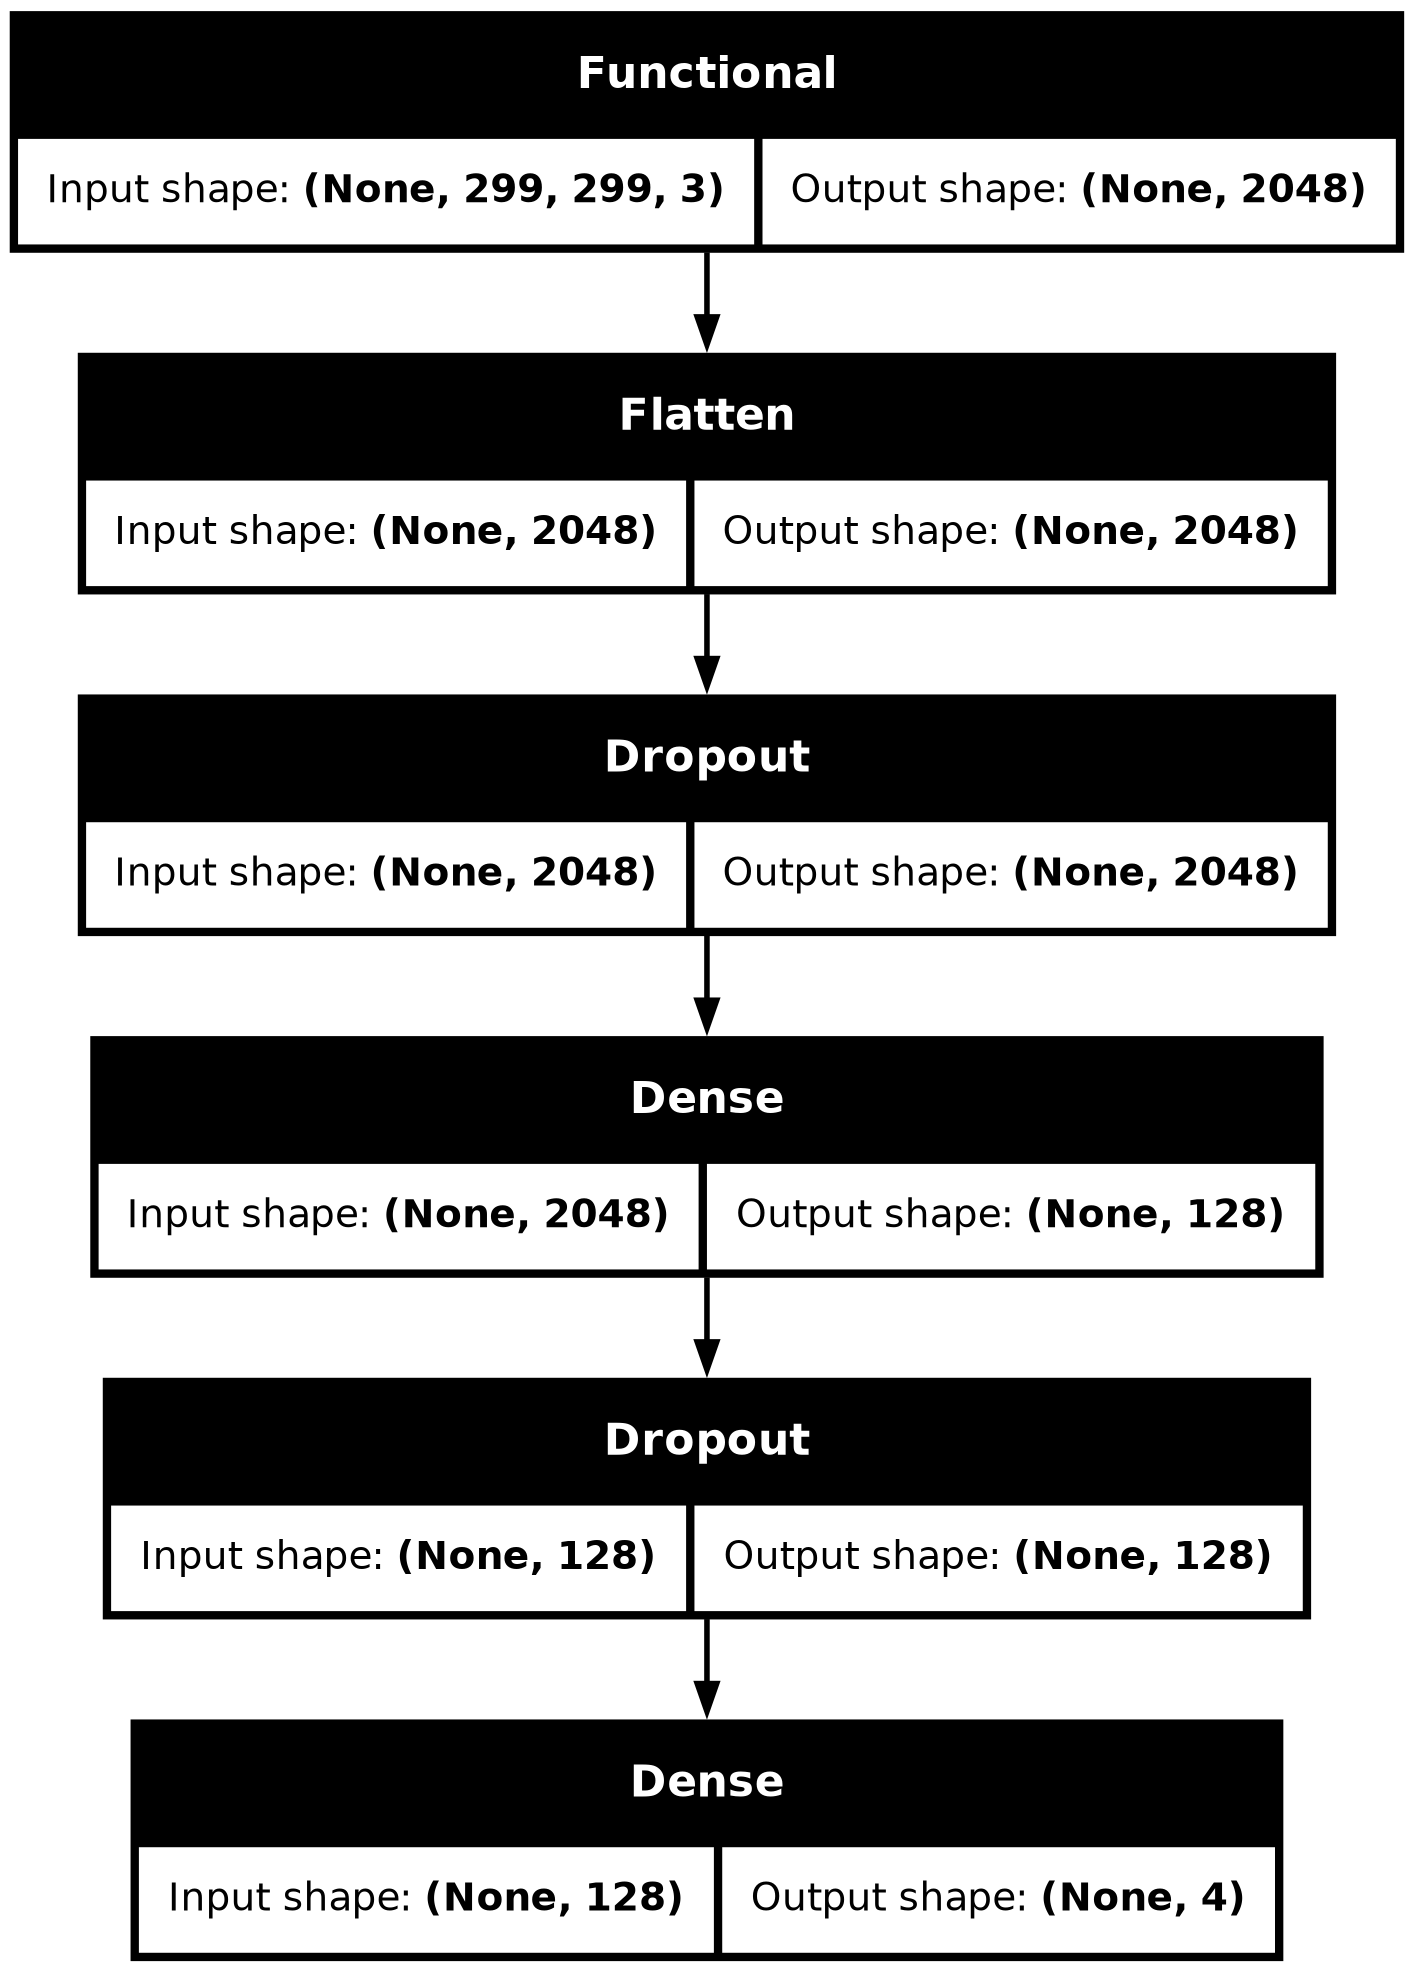

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
epochs = 10
history = model.fit(x= tr_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, shuffle= False)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.6806 - loss: 0.9136 - precision_1: 0.7840 - recall_1: 0.5347 - val_accuracy: 0.8553 - val_loss: 0.4412 - val_precision_1: 0.8768 - val_recall_1: 0.8471
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 147s 961ms/step - accuracy: 0.9508 - loss: 0.1522 - precision_1: 0.9549 - recall_1: 0.9467 - val_accuracy: 0.8821 - val_loss: 0.3748 - val_precision_1: 0.8974 - val_recall_1: 0.8775
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 147s 960ms/step - accuracy: 0.9670 - loss: 0.1040 - precision_1: 0.9703 - recall_1: 0.9636 - val_accuracy: 0.9463 - val_loss: 0.1521 - val_precision_1: 0.9495 - val_recall_1: 0.9428
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 146s 958ms/step - accuracy: 0.9826 - loss: 0.0683 - precision_1: 0.9838 - recall_1: 0.9806 - val_accuracy: 0.9767 - val_loss: 0.0601 - val_precision_1: 0.9778 - val_recall_1: 0.9755
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 146s 960ms/step - accuracy: 0.9810 - loss: 0.0658 - precision_1: 0.9828 - r

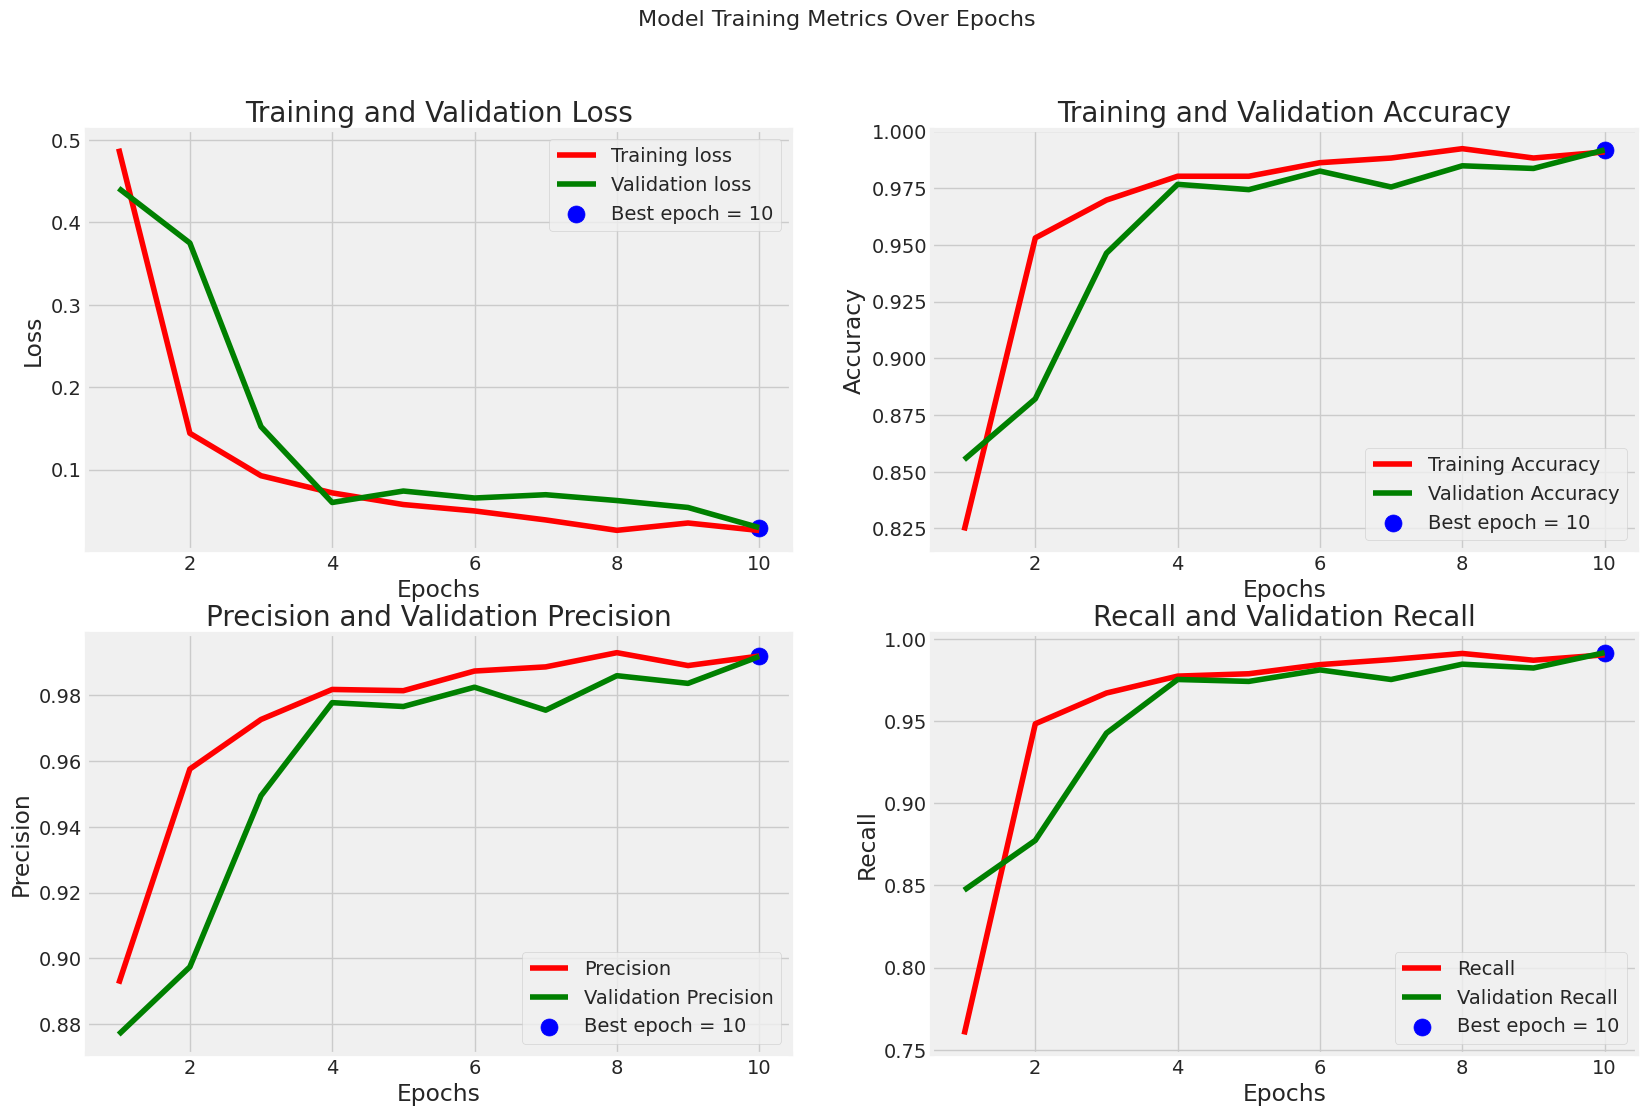

In [25]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision_1']
tr_recall = history.history['recall_1']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision_1']
val_recall = history.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [26]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


152/152 ━━━━━━━━━━━━━━━━━━━━ 112s 734ms/step - accuracy: 0.9963 - loss: 0.0149 - precision_1: 0.9963 - recall_1: 0.9949
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - accuracy: 0.9862 - loss: 0.0427 - precision_1: 0.9861 - recall_1: 0.9818
82/82 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.9938 - loss: 0.0166 - precision_1: 0.9943 - recall_1: 0.9938
Train Loss: 0.0160
Train Accuracy: 99.53%
--------------------
Validation Loss: 0.0597
Validation Accuracy: 98.48%
--------------------
Test Loss: 0.0347
Test Accuracy: 98.70%


In [27]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step


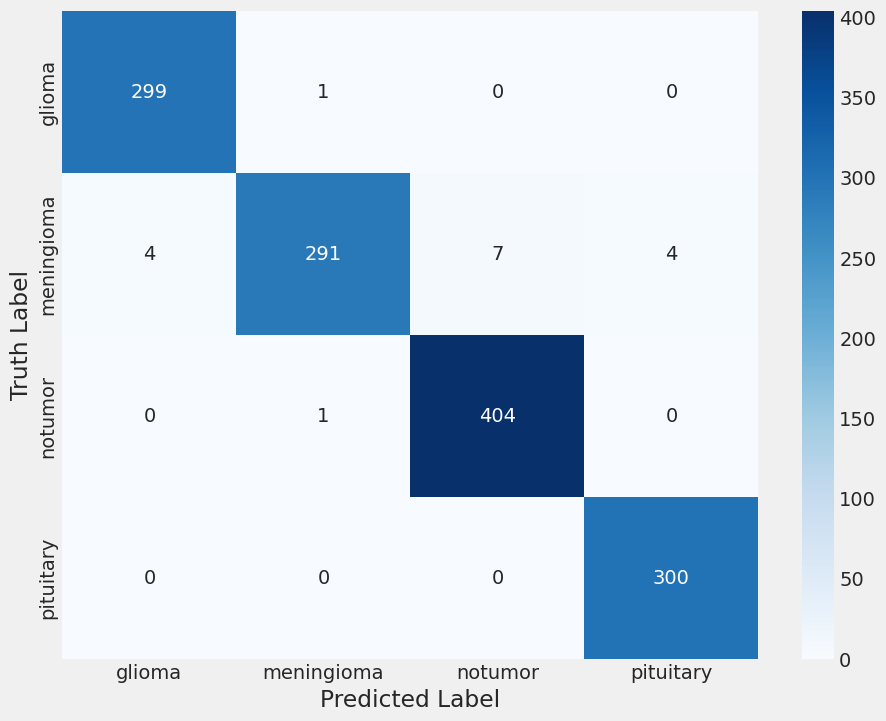

In [28]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [29]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       300
           1       0.99      0.95      0.97       306
           2       0.98      1.00      0.99       405
           3       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [39]:
# Convert the history object to a DataFrame
hist_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
hist_df.to_csv('Xception_training_history.csv', index=False)

In [40]:
hist_df = pd.read_csv('Xception_training_history.csv')
hist_df.head(10)

accuracy      loss  precision_1  recall_1  val_accuracy  val_loss  \
0  0.824099  0.489291     0.892278  0.759217      0.855309  0.441220   
1  0.953038  0.144041     0.957580  0.948507      0.882147  0.374835   
2  0.969722  0.092528     0.972659  0.967250      0.946324  0.152105   
3  0.980227  0.071718     0.981796  0.977549      0.976663  0.060062   
4  0.980227  0.057565     0.981416  0.978991      0.974329  0.073954   
5  0.986200  0.049813     0.987399  0.984552      0.982497  0.065490   
6  0.988260  0.038896     0.988660  0.987642      0.975496  0.069491   
7  0.992379  0.026273     0.992985  0.991349      0.984831  0.062434   
8  0.988260  0.035182     0.989063  0.987230      0.983664  0.054011   
9  0.990937  0.026086     0.991955  0.990525      0.991832  0.029583   

   val_precision_1  val_recall_1  
0         0.876812      0.847141  
1         0.897375      0.877480  
2         0.949471      0.942824  
3         0.977778      0.975496  
4         0.976608      0.974329  
5         0.982477      0.981330  
6         0.975496      0.975496  
7         0.985981      0.984831  
8         0.983645      0.982497  
9         0.991832      0.991832

In [41]:
# Assuming your model is named 'model'
model.save('Xception_model_Brain_Detection.h5')

## With EfficientNet architecture

In [42]:
batch_size = 32
img_size = (224, 224)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2),
                          rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(vl_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 4855 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(tr_gen.class_indices.keys()))  # Define number of classes in the dense layer

# Create pre-trained base model
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu',),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Summarize the model
model.build((None, *img_shape))  # Ensure layers are built with input shape
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

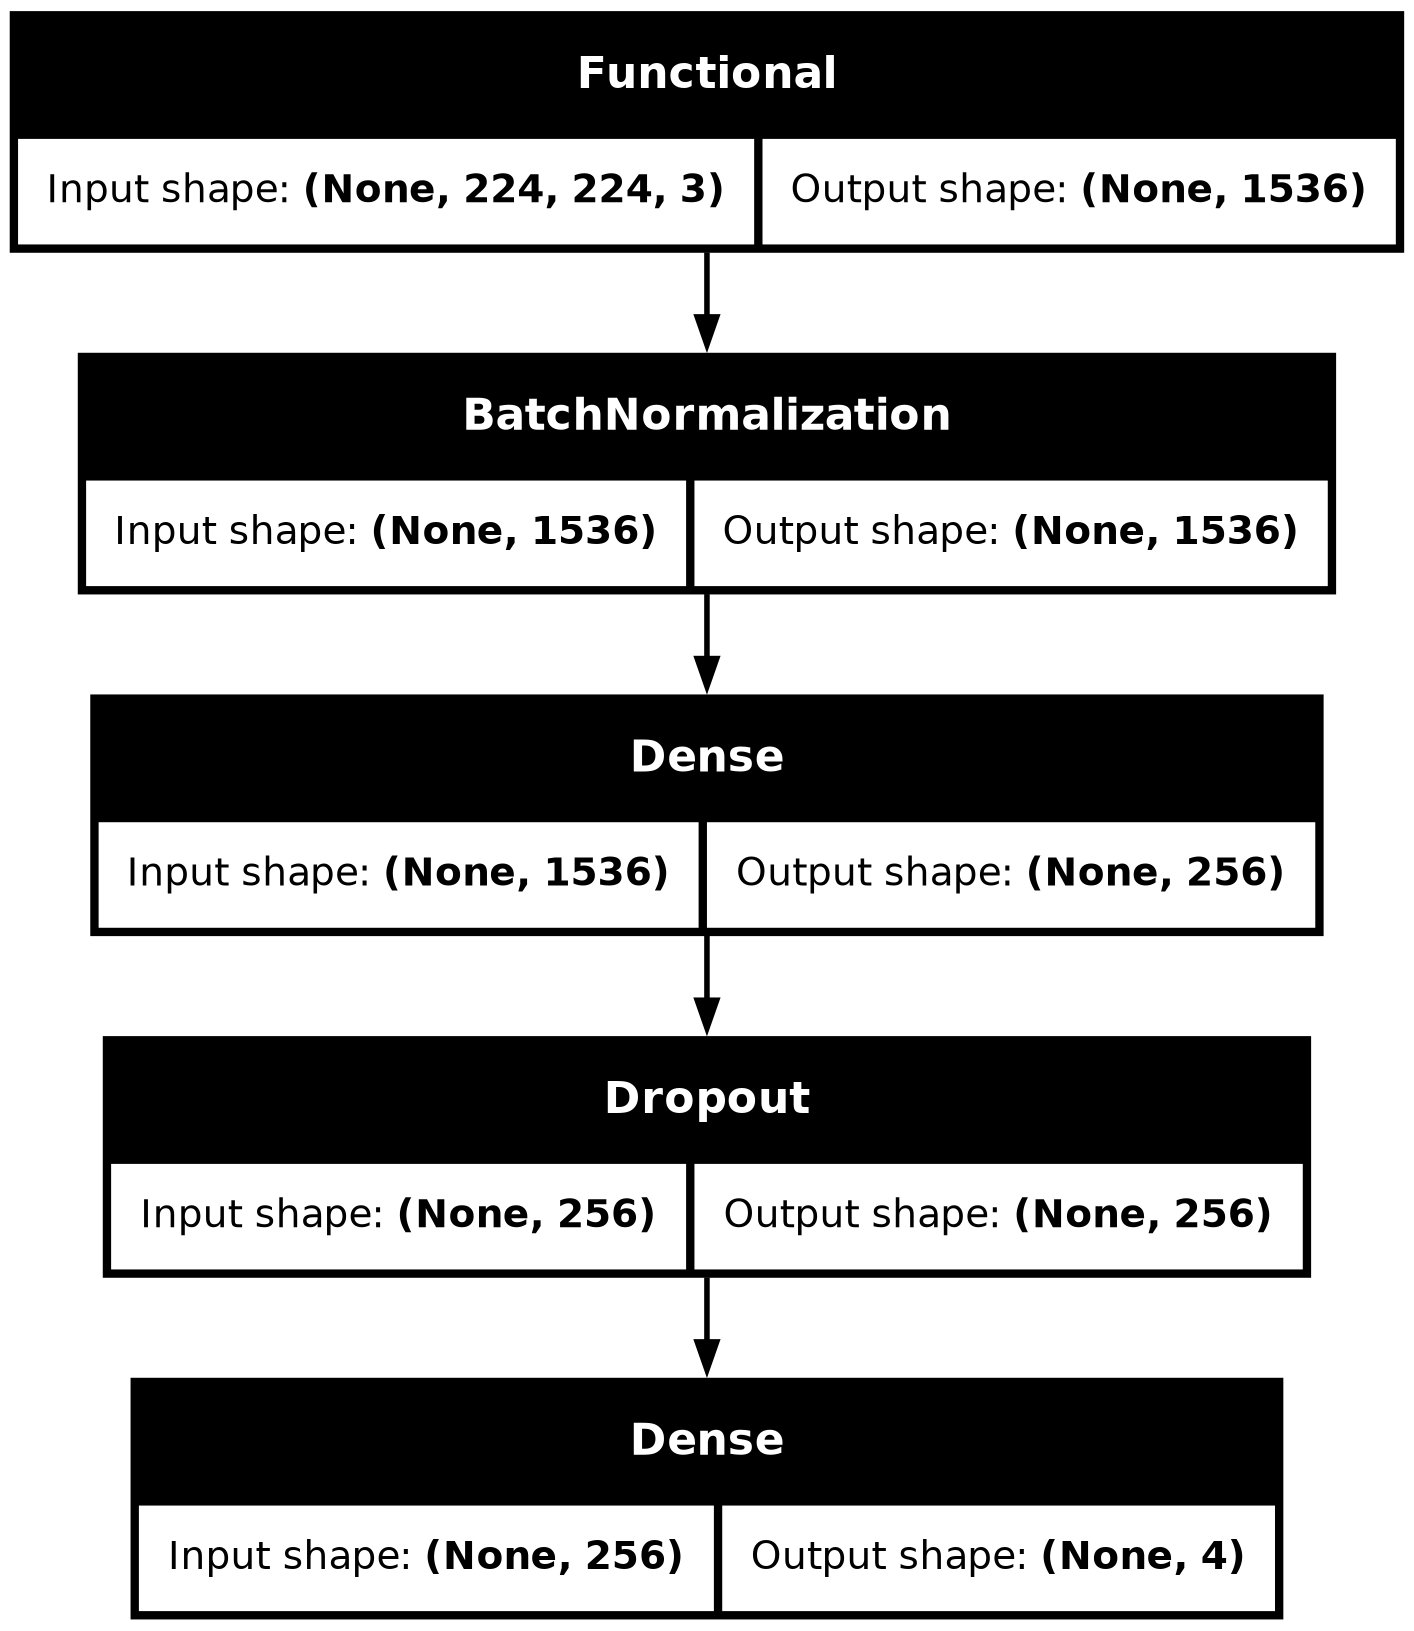

In [53]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
epochs = 10
hist = model.fit(x= tr_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, shuffle= False)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.7406 - loss: 0.7809 - precision_2: 0.7622 - recall_2: 0.7148 - val_accuracy: 0.2450 - val_loss: 2.7573 - val_precision_2: 0.2447 - val_recall_2: 0.2439
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 510ms/step - accuracy: 0.9054 - loss: 0.2854 - precision_2: 0.9097 - recall_2: 0.8942 - val_accuracy: 0.2882 - val_loss: 2.7405 - val_precision_2: 0.3045 - val_recall_2: 0.2754
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 513ms/step - accuracy: 0.9421 - loss: 0.1548 - precision_2: 0.9460 - recall_2: 0.9379 - val_accuracy: 0.4527 - val_loss: 2.6130 - val_precision_2: 0.4625 - val_recall_2: 0.4317
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 515ms/step - accuracy: 0.9611 - loss: 0.1120 - precision_2: 0.9640 - recall_2: 0.9591 - val_accuracy: 0.5904 - val_loss: 2.0833 - val_precision_2: 0.5943 - val_recall_2: 0.5881
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 517ms/step - accuracy: 0.9656 - loss: 0.1068 - precision_2: 0.9677 - recal

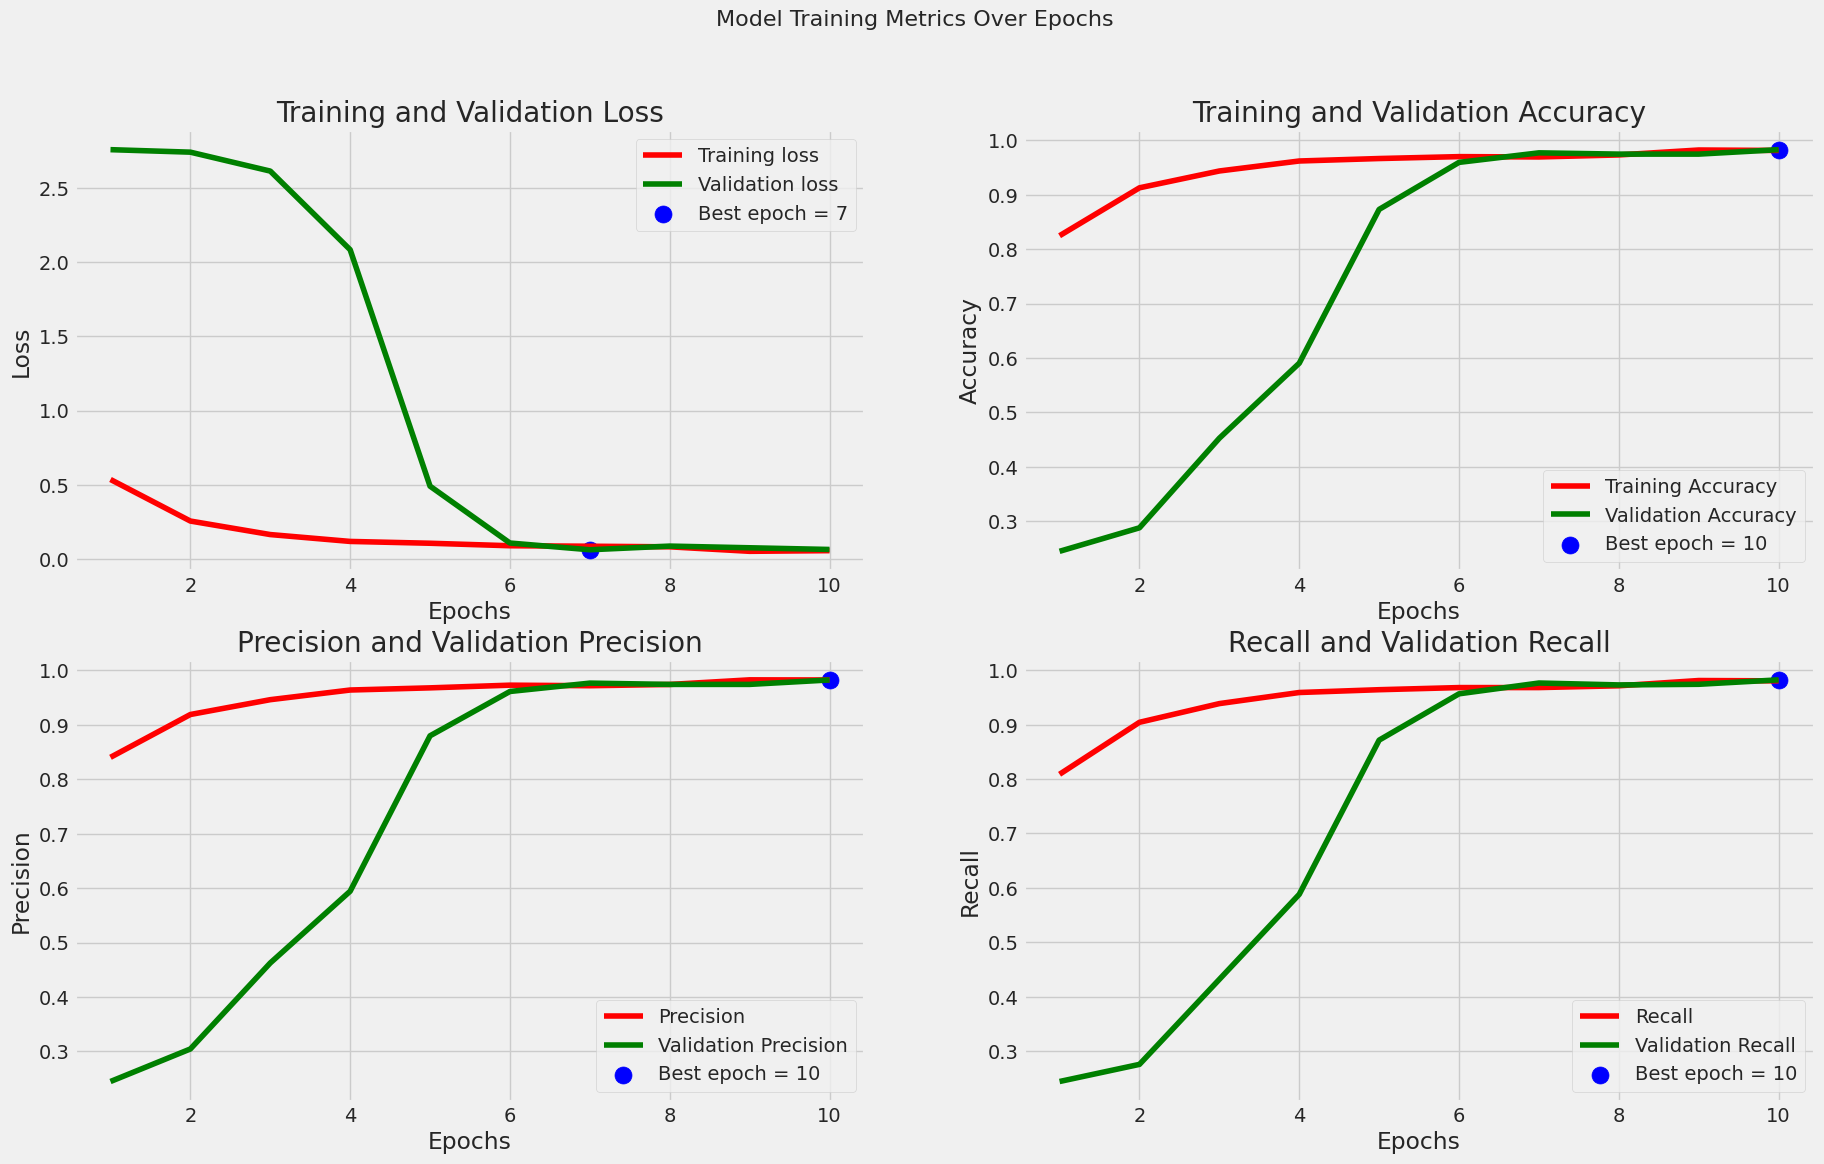

In [55]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_2']
tr_recall = hist.history['recall_2']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_2']
val_recall = hist.history['val_recall_2']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [56]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


152/152 ━━━━━━━━━━━━━━━━━━━━ 68s 448ms/step - accuracy: 0.9932 - loss: 0.0178 - precision_2: 0.9933 - recall_2: 0.9932
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.9882 - loss: 0.0393 - precision_2: 0.9884 - recall_2: 0.9882
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.9952 - loss: 0.0166 - precision_2: 0.9953 - recall_2: 0.9951
Train Loss: 0.0207
Train Accuracy: 99.30%
--------------------
Validation Loss: 0.0580
Validation Accuracy: 98.02%
--------------------
Test Loss: 0.0458
Test Accuracy: 98.78%


In [57]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step


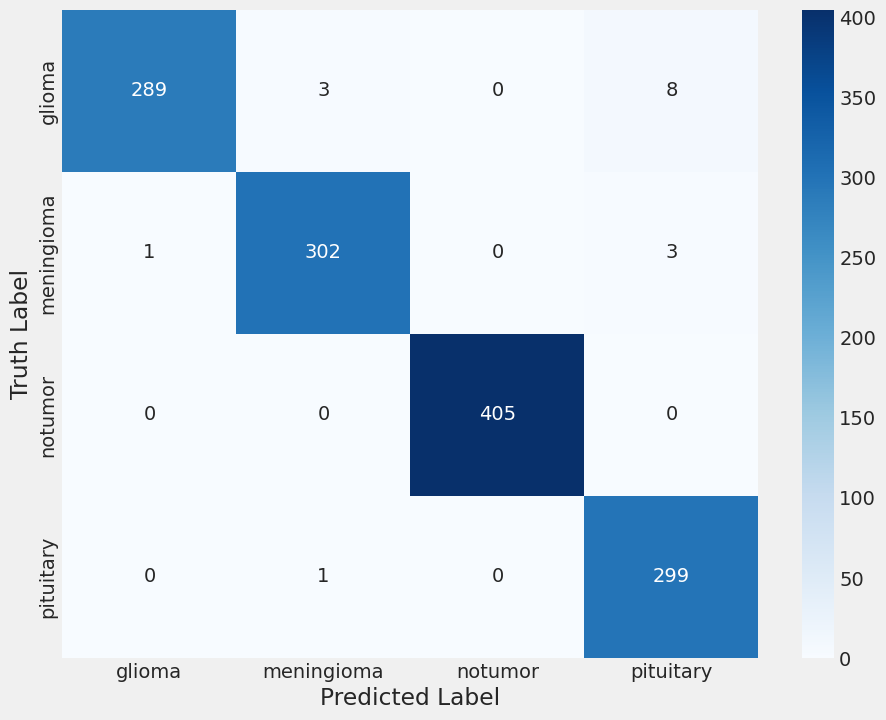

In [58]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [59]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       300
           1       0.99      0.99      0.99       306
           2       1.00      1.00      1.00       405
           3       0.96      1.00      0.98       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [62]:
# Convert the history object to a DataFrame
hist_df = pd.DataFrame(hist.history)

# Save the DataFrame to a CSV file
hist_df.to_csv('EfficientNet_training_history.csv', index=False)

In [63]:
hist_df = pd.read_csv('EfficientNet_training_history.csv')
hist_df.head(10)

accuracy      loss  precision_2  recall_2  val_accuracy  val_loss  \
0  0.824511  0.535636     0.840360  0.808857      0.245041  2.757336   
1  0.912461  0.255691     0.919004  0.904428      0.288215  2.740510   
2  0.943357  0.164668     0.946232  0.938826      0.452742  2.613036   
3  0.961689  0.118405     0.963983  0.959217      0.590432  2.083341   
4  0.966220  0.106154     0.967955  0.964367      0.872812  0.490618   
5  0.969722  0.089327     0.972889  0.968280      0.959160  0.107639   
6  0.969104  0.086111     0.971883  0.968280      0.976663  0.062246   
7  0.972812  0.082155     0.974184  0.971576      0.974329  0.086986   
8  0.981874  0.051790     0.982673  0.981256      0.974329  0.075634   
9  0.981050  0.056249     0.982460  0.980639      0.982497  0.064255   

   val_precision_2  val_recall_2  
0         0.244731      0.243874  
1         0.304516      0.275379  
2         0.462500      0.431739  
3         0.594340      0.588098  
4         0.879859      0.871645  
5         0.961313      0.956826  
6         0.976663      0.976663  
7         0.974299      0.973162  
8         0.974329      0.974329  
9         0.982497      0.982497

In [64]:
# Assuming your model is named 'model'
model.save('EfficientNet_model_Brain_Detection.h5')

In [ ]:
model.predict ("C:\Users\Dell\OneDrive - Egyptian E-Learning University\Desktop\test")